# 08 — Transformación Proyectiva (Homografía) en 2D

## Teoría (coordenadas homogéneas, matriz 3×3)

La **transformación proyectiva** (o **homografía**) mapea puntos de un plano a otro usando una matriz $( \mathbf{H} \in \mathbb{R}^{3\times 3} )$ definida **a escala** (hasta un factor).
En **coordenadas homogéneas**:
$
\begin{bmatrix}
x_2 \\ y_2 \\ w
\end{bmatrix}$
$=
\mathbf{H}$
$\begin{bmatrix}
x_1 \\ y_1 \\ 1
\end{bmatrix}$,
$\qquad
\mathbf{H}=$
$\begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33}
\end{bmatrix}.
$

Para volver a coordenadas cartesianas:
$
x'_2 = \frac{x_2}{w}, \qquad y'_2 = \frac{y_2}{w}.
$

Una homografía está determinada (salvo escala) por **cuatro pares de puntos no colineales** (4 correspondencias punto a punto).
OpenCV provee:
- `cv2.getPerspectiveTransform(src_pts, dst_pts)` cuando damos **4 puntos** exactos.
- `cv2.findHomography(src_pts, dst_pts, method=RANSAC)` para datos con ruido/outliers.

La aplicación sobre una imagen se hace con:
- `cv2.warpPerspective(img, H, (W, H))`.


## Implementación en OpenCV

1. **Deformación proyectiva** controlada: moveremos las esquinas de la imagen para crear una vista "trapezoidal".  
2. **Rectificación** de un cuadrilátero interno: seleccionar una región y llevarla a un rectángulo (simulando *bird's-eye*).  


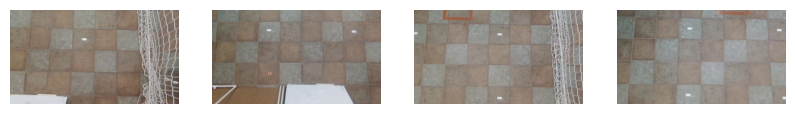

In [ ]:
# ✅ Importar librerías y cargar imagen
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Ruta donde están las imágenes
img_dir = r"C:\Users\rrm21\Documents\Vision_en_Robotica\dron_images"

# Cargar imágenes
p1 = cv2.imread(os.path.join(img_dir, "p1.png"))
p2 = cv2.imread(os.path.join(img_dir, "p2.png"))
p3 = cv2.imread(os.path.join(img_dir, "p3.png"))
p4 = cv2.imread(os.path.join(img_dir, "p4.png"))


# Convertir a RGB para mostrar en matplotlib
p1_rgb, p2_rgb, p3_rgb, p4_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in [p1,p2,p3,p4]]

plt.figure(figsize=(10,5))
for i,img in enumerate([p1_rgb,p2_rgb,p3_rgb,p4_rgb],1):
    plt.subplot(1,4,i)
    plt.imshow(img)
    plt.axis("off")
plt.show()


### Ejemplo 1 — Deformación proyectiva de toda la imagen (mover esquinas)

Definimos 4 puntos **origen** (las esquinas) y 4 puntos **destino** (un trapecio). Usamos `getPerspectiveTransform` + `warpPerspective`.


Mosaico guardado en: C:\Users\rrm21\Documents\Vision_en_Robotica\dron_images\mosaico.png


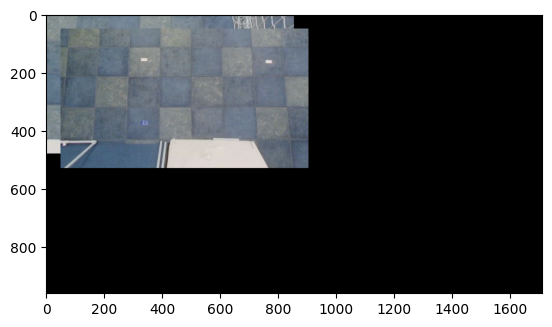

In [8]:
# Puntos en la imagen p2
pts_p2 = np.float32([[50,50],[450,50],[50,450],[450,450]])

# A dónde quieres llevarlos en p1
pts_p1 = np.float32([[100,100],[500,100],[100,500],[500,500]])

M = cv2.getPerspectiveTransform(pts_p2, pts_p1)
p2_warped = cv2.warpPerspective(p2, M, (p1.shape[1]*2, p1.shape[0]*2))

# Creamos un lienzo grande
mosaic = np.zeros((p1.shape[0]*2, p1.shape[1]*2, 3), dtype=np.uint8)

# Pegamos la imagen base
mosaic[0:p1.shape[0], 0:p1.shape[1]] = p1

# Encima colocamos la alineada
mask = p2_warped > 0
mosaic[mask] = p2_warped[mask]

output_path = os.path.join(img_dir, "mosaico.png")
cv2.imwrite(output_path, mosaic)
print("Mosaico guardado en:", output_path)

plt.imshow(mosaic);


### Ejemplo 2 — Rectificación de un cuadrilátero interno (*bird's‑eye* de una región)

Seleccionamos un **cuadrilátero** dentro de la imagen (simulando un plano inclinado) y lo mapeamos a un **rectángulo** de salida.
Esto es análogo a **rectificar un plano** (p. ej., el piso o una hoja vista en perspectiva).